# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme

In [ ]:
!pip install tensorflow 

In [ ]:
!pip install tensorflow-gpu 

In [ ]:
!pip install opencv-python 

In [ ]:
!pip install matplotlib

In [ ]:
!pip install albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
uuid.uuid1()

UUID('6edeb72a-c881-11ee-8ba6-2ac5e9ea2120')

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [4]:
!labelme

zsh:1: command not found: labelme


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [18]:
images = tf.data.Dataset.list_files("data/images/*.jpg", shuffle=False)

In [19]:
images.as_numpy_iterator().next()

b'data/images/13013ae6-cf3a-11ec-8abb-2ac5e9ea2120.jpg'

In [20]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [21]:
images = images.map(load_image)

In [22]:
images.as_numpy_iterator().next()

2022-05-15 16:55:46.651549: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[144, 172, 113],
        [128, 156,  97],
        [142, 170, 111],
        ...,
        [131, 152,  93],
        [125, 145,  86],
        [128, 148,  89]],

       [[142, 170, 111],
        [129, 157,  98],
        [139, 167, 108],
        ...,
        [125, 146,  87],
        [132, 152,  93],
        [135, 155,  96]],

       [[144, 169, 111],
        [136, 161, 103],
        [142, 167, 109],
        ...,
        [131, 152,  95],
        [128, 148,  89],
        [136, 156,  97]],

       ...,

       [[101, 125,  77],
        [103, 127,  79],
        [100, 122,  75],
        ...,
        [103, 119,  74],
        [101, 116,  73],
        [106, 121,  78]],

       [[105, 129,  81],
        [104, 128,  80],
        [101, 123,  76],
        ...,
        [102, 117,  74],
        [100, 115,  74],
        [104, 119,  78]],

       [[102, 126,  78],
        [101, 125,  77],
        [102, 124,  77],
        ...,
        [102, 117,  74],
        [ 95, 110,  69],
        [ 92, 107,  66]]

In [23]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [24]:
image_generator = images.batch(4).as_numpy_iterator()

In [25]:
plot_images = image_generator.next()

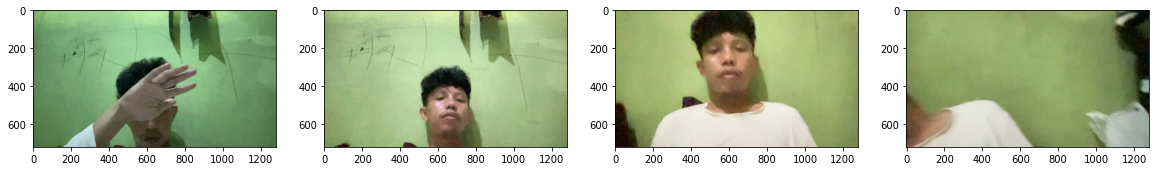

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [30]:
30*.7 # 21 to train

21.0

In [31]:
30*.15 # 5 and 4 to test and val

4.5

### 3.2 Move the Matching Labels

In [32]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

In [34]:
img = cv2.imread(os.path.join('data','train', 'images','0fecaea8-cf3a-11ec-8abb-2ac5e9ea2120.jpg'))

In [36]:
img.shape

(720, 1280, 3)

### 4.1 Setup Albumentations Transform Pipeline

In [147]:
import albumentations as alb

In [148]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [149]:
img = cv2.imread(os.path.join('data','train', 'images','0fecaea8-cf3a-11ec-8abb-2ac5e9ea2120.jpg'))

In [150]:
img

array([[[ 87, 130, 115],
        [ 88, 131, 116],
        [ 92, 135, 120],
        ...,
        [ 57, 102,  83],
        [ 51,  95,  78],
        [ 44,  88,  71]],

       [[ 93, 136, 121],
        [ 95, 138, 123],
        [ 96, 139, 124],
        ...,
        [ 54,  99,  80],
        [ 51,  95,  78],
        [ 47,  91,  74]],

       [[ 86, 129, 114],
        [ 91, 134, 119],
        [ 96, 139, 124],
        ...,
        [ 51,  95,  78],
        [ 54,  98,  81],
        [ 54,  98,  81]],

       ...,

       [[ 45,  79,  62],
        [ 43,  77,  60],
        [ 42,  75,  60],
        ...,
        [ 37,  67,  56],
        [ 37,  69,  58],
        [ 35,  67,  56]],

       [[ 45,  78,  63],
        [ 42,  75,  60],
        [ 40,  73,  58],
        ...,
        [ 36,  68,  57],
        [ 36,  67,  58],
        [ 33,  64,  55]],

       [[ 42,  75,  60],
        [ 40,  73,  58],
        [ 41,  74,  59],
        ...,
        [ 34,  66,  55],
        [ 33,  64,  55],
        [ 32,  63,  54]]

In [151]:
with open(os.path.join('data', 'train', 'labels', '0fecaea8-cf3a-11ec-8abb-2ac5e9ea2120.json'), 'r') as f:
    label = json.load(f)

In [152]:
label

{'version': '4.5.12',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[495.48837209302326, 321.6744186046512],
    [782.6976744186047, 674.0]],
   'group_id': None,
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '../images/0fecaea8-cf3a-11ec-8abb-2ac5e9ea2120.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWV

In [153]:
label['shapes'][0]['points']

[[495.48837209302326, 321.6744186046512], [782.6976744186047, 674.0]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [170]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [171]:
coords

[495.48837209302326, 321.6744186046512, 782.6976744186047, 674.0]

In [172]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [173]:
coords

[0.38710029069767443,
 0.4467700258397933,
 0.6114825581395349,
 0.9361111111111111]

### 4.4 Apply Augmentations and View Results

In [174]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [175]:
augmented['bboxes'][0][2:]

(0.508217054263566, 0.6851679586563307)

In [176]:
augmented['bboxes']

[(0.0, 0.0, 0.508217054263566, 0.6851679586563307)]

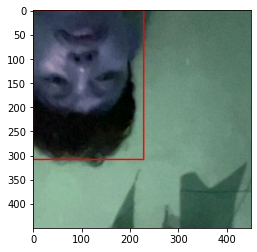

In [177]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [179]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(20):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [187]:
train_images = tf.data.Dataset.list_files("aug_data/train/images/*.jpg",shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [188]:
test_images = tf.data.Dataset.list_files("aug_data/test/images/*.jpg", shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [189]:
val_images = tf.data.Dataset.list_files("aug_data/val/images/*.jpg", shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [190]:
train_images.as_numpy_iterator().next()

array([[[0.5701593 , 0.6612745 , 0.45735294],
        [0.54601717, 0.63621324, 0.42444852],
        [0.5604779 , 0.65067405, 0.43890932],
        ...,
        [0.70980394, 0.8117647 , 0.5598039 ],
        [0.7122549 , 0.81421566, 0.56715685],
        [0.7137868 , 0.81574756, 0.565625  ]],

       [[0.5601103 , 0.65294117, 0.4490196 ],
        [0.55692405, 0.6471201 , 0.43621323],
        [0.5328431 , 0.6230392 , 0.41127452],
        ...,
        [0.7058211 , 0.8077819 , 0.56072307],
        [0.7063113 , 0.80827206, 0.56219363],
        [0.7076593 , 0.8096201 , 0.5629289 ]],

       [[0.5310662 , 0.6251838 , 0.42126226],
        [0.54356617, 0.63376224, 0.42984068],
        [0.5509191 , 0.6411152 , 0.43719363],
        ...,
        [0.7083946 , 0.81035537, 0.5711397 ],
        [0.7019608 , 0.8039216 , 0.5647059 ],
        [0.71697307, 0.81893384, 0.5797181 ]],

       ...,

       [[0.34332108, 0.40998775, 0.27665442],
        [0.3533701 , 0.4190564 , 0.28621325],
        [0.3332108 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [191]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [192]:
train_labels = tf.data.Dataset.list_files("aug_data/train/labels/*.json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [193]:
test_labels = tf.data.Dataset.list_files("aug_data/train/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [194]:
val_labels = tf.data.Dataset.list_files("aug_data/train/labels/*.json", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [195]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.6255, 0.6035, 1.    , 1.    ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [196]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(420, 420, 100, 420, 80, 420)

### 7.2 Create Final Datasets (Images/Labels)

In [197]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [198]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [199]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [200]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.2296, 0.477 , 0.8677, 1.    ],
        [0.933 , 0.3   , 1.    , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.3416, 0.97  ],
        [0.    , 0.1345, 0.3684, 1.    ],
        [0.684 , 0.    , 1.    , 1.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

### 7.3 View Images and Annotations

In [201]:
data_samples = train.as_numpy_iterator()

In [202]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


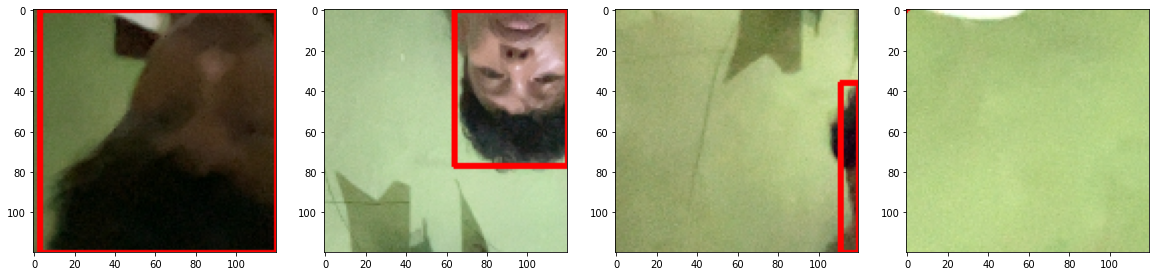

In [203]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [204]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [205]:
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 1410s 24us/step


In [206]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [207]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [208]:
facetracker = build_model()

In [209]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [210]:
X, y = train.as_numpy_iterator().next()

In [211]:
X.shape

(8, 120, 120, 3)

In [212]:
classes, coords = facetracker.predict(X)

2022-05-15 18:59:55.615293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [213]:
classes, coords

(array([[0.6209004 ],
        [0.59530336],
        [0.5612242 ],
        [0.556418  ],
        [0.5910065 ],
        [0.6286593 ],
        [0.5592295 ],
        [0.589365  ]], dtype=float32),
 array([[0.3833836 , 0.46926484, 0.5221608 , 0.3992183 ],
        [0.48926598, 0.3637448 , 0.4438363 , 0.48946   ],
        [0.54099166, 0.4102488 , 0.4002825 , 0.4097499 ],
        [0.37229273, 0.43179795, 0.4648331 , 0.46160957],
        [0.4190597 , 0.37812543, 0.48486283, 0.43786308],
        [0.4400914 , 0.36150527, 0.44411573, 0.48160657],
        [0.38457018, 0.4393193 , 0.31966248, 0.5328249 ],
        [0.33359826, 0.4161822 , 0.48216054, 0.44275436]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [214]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [215]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [216]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [217]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [218]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.434784>

In [219]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6089634>

In [220]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.434784>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [221]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [222]:
model = FaceTracker(facetracker)

In [223]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [224]:
logdir='logs'

In [225]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [226]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2022-05-15 19:00:38.897719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - total_loss: 1.9251 - class_loss: 0.2851 - regress_loss: 1.7825

2022-05-15 19:00:51.578804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 14s 184ms/step - total_loss: 1.9091 - class_loss: 0.2826 - regress_loss: 1.7678 - val_total_loss: 5.4048 - val_class_loss: 1.7388 - val_regress_loss: 4.5354
Epoch 2/10
53/53 [==============================] - 9s 170ms/step - total_loss: 0.7347 - class_loss: 0.1124 - regress_loss: 0.6785 - val_total_loss: 3.4778 - val_class_loss: 0.8206 - val_regress_loss: 3.0675
Epoch 3/10
53/53 [==============================] - 9s 169ms/step - total_loss: 0.4855 - class_loss: 0.0946 - regress_loss: 0.4382 - val_total_loss: 3.6875 - val_class_loss: 0.7333 - val_regress_loss: 3.3208
Epoch 4/10
53/53 [==============================] - 9s 170ms/step - total_loss: 0.3071 - class_loss: 0.0605 - regress_loss: 0.2768 - val_total_loss: 4.2940 - val_class_loss: 2.2121 - val_regress_loss: 3.1879
Epoch 5/10
53/53 [==============================] - 10s 171ms/step - total_loss: 0.2330 - class_loss: 0.0477 - regress_loss: 0.2091 - val_total_loss: 4.1728 - val_class_loss: 0.4

### 10.3 Plot Performance

In [227]:
hist.history

{'total_loss': [1.0607798099517822,
  0.1332497000694275,
  0.06544405221939087,
  0.03271370753645897,
  0.037780847400426865,
  0.028512153774499893,
  0.05909668281674385,
  0.06282263994216919,
  0.0068663633428514,
  0.20040354132652283],
 'class_loss': [0.15195232629776,
  0.012288670986890793,
  0.036262303590774536,
  0.005310004111379385,
  0.012419598177075386,
  0.0011256422149017453,
  0.0004870600823778659,
  0.04613624885678291,
  8.262958317573066e-07,
  0.13125605881214142],
 'regress_loss': [0.9848036766052246,
  0.12710537016391754,
  0.0473129004240036,
  0.03005870431661606,
  0.031571049243211746,
  0.02794933319091797,
  0.0588531531393528,
  0.03975451737642288,
  0.006865950301289558,
  0.13477551937103271],
 'val_total_loss': [5.404788970947266,
  3.4777684211730957,
  3.6874682903289795,
  4.29395055770874,
  4.172840595245361,
  6.316145896911621,
  3.519613742828369,
  5.342404842376709,
  3.6131319999694824,
  2.6655848026275635],
 'val_class_loss': [1.7388

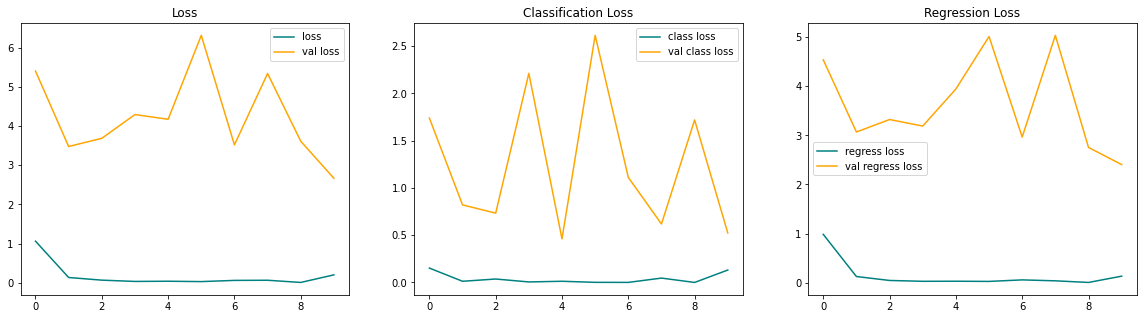

In [228]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [229]:
test_data = test.as_numpy_iterator()

In [230]:
test_sample = test_data.next()

In [231]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


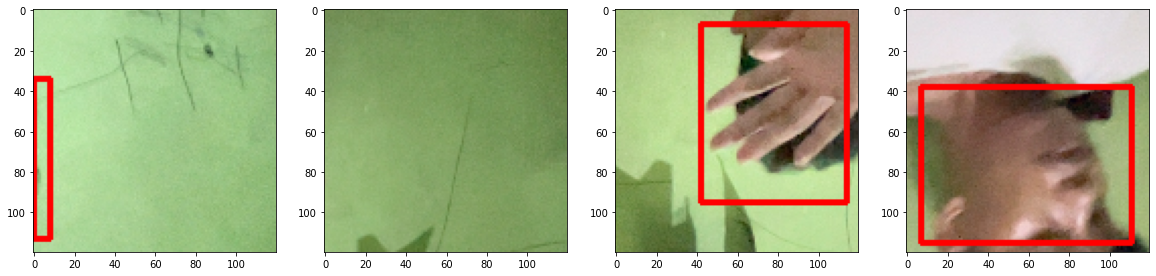

In [232]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [7]:
from tensorflow.keras.models import load_model

In [8]:
facetracker.save('facetracker.h5')

In [9]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [15]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

2023-02-24 22:02:17.977224: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 22:02:18.043682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
1   HIToolbox                           0x000000018e4bc5c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000018e4bc188 _ZN15MenuBarInstance14EnableAutoShowEv + 60
3   HIToolbox                           0x000000018e4298bc _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1184
4   HIToolbox                           0x000000018e4bc004 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 180
5   AppKit                              0x00000001882abd30 -[NSApplication _setPresentationOptions:instance:flags:] + 956
6   AppKit                              0x000000018814193c -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 404
7   CoreF

1   HIToolbox                           0x000000018e44790c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x000000018e4bcfbc _ZN15MenuBarInstance15DisableAutoShowEv + 36
3   HIToolbox                           0x000000018e4bd0b0 _ZN15MenuBarInstanceD2Ev + 128
4   HIToolbox                           0x000000018e4bcee0 _ZN15MenuBarInstance7ReleaseEv + 56
5   AppKit                              0x00000001886494dc -[NSHIPresentationInstance discard] + 228
6   AppKit                              0x0000000188a088b4 -[_NSFullScreenSpace(PresentationInstance) discardPresentationInstance] + 32
7   AppKit                              0x0000000188a0890c -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 64
8   AppKit                              0x0000000188862968 -[_NSExitFullScreenTransitionController _doSucceededToExitFullScreen] + 40
9   AppKit                              0x0000000188863440 __63-[_NSExitFullScreenT

In [13]:
import tensorflow as tf

In [14]:
import numpy as np